# Evolving a Lunar Lander with differentiable Genetic Programming

## Installation
To install the required libraries run the command:

In [50]:
#test change
# !pip install -r requirements.txt

## Imports
Imports from the standard genepro-multi library are done here. Any adjustments (e.g. different operators) should be made in the notebook. For example:

```
class SmoothOperator(Node):
  def __init__(self):
    super(SmoothOperator,self).__init__()
    self.arity = 1
    self.symb = "SmoothOperator"

  def _get_args_repr(self, args):
    return self._get_typical_repr(args,'before')

  def get_output(self, X):
    c_outs = self._get_child_outputs(X)
    return np.smoothOperation(c_outs[0])

  def get_output_pt(self, X):
    c_outs = self._get_child_outputs_pt(X)
    return torch.smoothOperation(c_outs[0])
```

In [51]:
%reload_ext autoreload
%autoreload 2
import importlib
import genepro
importlib.reload(genepro)

import gymnasium as gym

from genepro.node_impl import *
from genepro.evo import Evolution
from genepro.node_impl import Constant
# importlib.reload(genepro.evo)
# importlib.reload(genepro.node_impl)

import torch
import torch.optim as optim

import random
import os
import copy
from collections import namedtuple, deque

import matplotlib.pyplot as plt
from matplotlib import animation

import time

In [52]:
#workaround for error 15:
#OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Reinforcement Learning Setup
Here we first setup the Gymnasium environment. Please see https://gymnasium.farama.org/environments/box2d/lunar_lander/ for more information on the environment. 

Then a memory buffer is made. This is a buffer in which state transitions are stored. When the buffer reaches its maximum capacity old transitions are replaced by new ones.

A frame buffer is initialised used to later store animation frames of the environment.

In [53]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [54]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity): #specifies the max length of the memory buffer by making deque() object
        self.memory = deque([], maxlen=capacity)

    def push(self, *args): #pushes new transition(state,action,nextstate, reward) onto memory
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size): #returns sample batch of transitions in memory
        return random.sample(self.memory, batch_size)

    def __len__(self): #returns current length of the memory
        return len(self.memory)

    def __iadd__(self, other): #changes and returns the existing memory
      self.memory += other.memory
      return self 

    def __add__(self, other): #leaves existing memory but creates and returns new combined memory
      self.memory = self.memory + other.memory 
      return self

In [55]:
frames = []

## Fitness Function

Here you get to be creative. The default setup evaluates 5 episodes of 300 frames. Think of what action to pick and what fitness function to use. The Multi-tree takes an input of $n \times d$ where $n$ is a batch of size 1.

In [56]:
def fitness_function_pt(multitree, num_episodes=5, episode_duration=300, render=False, ignore_done=False):
  memory = ReplayMemory(10000)
  rewards = []

  for _ in range(num_episodes):
    # get initial state of the environment
    observation = env.reset() #resets to initial state (first seed is chosen randomly, then stays the same)
    observation = observation[0] #returns metric(?) of first observation
    observation = np.array([(observation[0]/90), (observation[1]/90), (observation[2]/5), (observation[3]/5), (observation[4]/3.1415927), (observation[5]/5), observation[6], observation[7]])

    for _ in range(episode_duration):
      if render:
        frames.append(env.render())

      input_sample = torch.from_numpy(observation.reshape((1,-1))).float() #creates a tensor from a numpy array (shared memory)
      
      action = torch.argmax(multitree.get_output_pt(input_sample))
      observation, reward, terminated, truncated, info = env.step(action.item()) #updates environment with input action
      observation = np.array([(observation[0]/90), (observation[1]/90), (observation[2]/5), (observation[3]/5), (observation[4]/3.1415927), (observation[5]/5), observation[6], observation[7]])
      
      rewards.append(reward)
      output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      memory.push(input_sample, torch.tensor([[action.item()]]), output_sample, torch.tensor([reward]))
      if (terminated or truncated) and not ignore_done:
        break

  fitness = np.sum(rewards)
  
  return fitness, memory

## Evolution Setup
Here the leaf and internal nodes are defined. Think about the odds of sampling a constant in this default configurations. Also think about any operators that could be useful and add them here. 

Adjust the population size (multiple of 8 if you want to use the standard tournament selection), max generations and max tree size to taste. Be aware that each of these settings can increase the runtime.

In [57]:
!python symbolic_dqn\main.py

Is GPU available: False



  0%|          | 0/500 [00:00<?, ?it/s]
Episode 0 Steps | CPU 34.3 | RAM 95.1:   0%|          | 0/500 [00:00<?, ?it/s]
Episode 0 Steps | CPU 34.3 | RAM 95.1:   0%|          | 0/500 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "C:\Users\Sarah\Documents\Important\Evolutionary Algorithms\pycharm\symbolic_dqn\main.py", line 97, in <module>
    next_states, rewards, done, tree_full = env.step(actions)
  File "C:\Users\Sarah\Documents\Important\Evolutionary Algorithms\pycharm\symbolic_dqn\model.py", line 51, in step
    state_eval = self.state.evaluate(self.main_env_state)[0] #Added index to mirror fitness_function_pt()
  File "C:\Users\Sarah\Documents\Important\Evolutionary Algorithms\pycharm\symbolic_dqn\expression_tree.py", line 63, in evaluate
    output = self.multitree.get_output_pt(main_env_state)
  File "C:\Users\Sarah\Documents\Important\Evolutionary Algorithms\pycharm\genepro\multitree.py", line 16, in get_output_pt
    output.append(child.get_output_pt(x).view(-1,1)

In [58]:
num_features = env.observation_space.shape[0]
leaf_nodes = [Feature(i) for i in range(num_features)]
leaf_nodes = leaf_nodes + [Constant()] # Think about the probability of sampling a coefficient
internal_nodes = [Plus(),Minus(),Times(),Div()] #Add your own operators here

evo = Evolution(
  fitness_function_pt, internal_nodes, leaf_nodes,
  4,
  pop_size=16,
  max_gens=2,
  max_tree_size=31,
  n_jobs=4,
  verbose=True)

# Test

In [59]:
def get_test_score(tree):
    rewards = []

    for i in range(5): #run 5 episodes for baseline
      # get initial state
      observation = env.reset(seed=i)
      observation = observation[0]
      observation = np.array([(observation[0]/90), (observation[1]/90), (observation[2]/5), (observation[3]/5), (observation[4]/3.1415927), (observation[5]/5), observation[6], observation[7]])

      for _ in range(300): #300 time steps for baseline
        # build up the input sample for GP
        input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        # get output (squeezing because it is encapsulated in an array)
        output = tree.get_output_pt(input_sample)
        action = torch.argmax(output) # What goes here?
        observation, reward, terminated, truncated, info = env.step(action.item())
        observation = np.array([(observation[0]/90), (observation[1]/90), (observation[2]/5), (observation[3]/5), (observation[4]/3.1415927), (observation[5]/5), observation[6], observation[7]])

        rewards.append(reward)


        output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        if (terminated or truncated):
            break

    fitness = np.sum(rewards)
    
    return fitness


In [60]:
def coefficient_optimisation():
    for best in evo.population:
        batch_size = 128
        GAMMA = 0.99

        constants = best.get_subtrees_consts()
        if len(constants)>0:
            optimizer = optim.AdamW(constants, lr=1e-3, amsgrad=True)

        for _ in range(500):

            if len(constants)>0 and len(evo.memory)>batch_size:
                target_tree = copy.deepcopy(best)

                transitions = evo.memory.sample(batch_size)
                batch = Transition(*zip(*transitions))
                
                non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                    batch.next_state)), dtype=torch.bool)

                non_final_next_states = torch.cat([s for s in batch.next_state
                                                        if s is not None])
                state_batch = torch.cat(batch.state)
                action_batch = torch.cat(batch.action)
                reward_batch = torch.cat(batch.reward)

                state_action_values = best.get_output_pt(state_batch).gather(1, action_batch)
                next_state_values = torch.zeros(batch_size, dtype=torch.float)
                with torch.no_grad():
                    next_state_values[non_final_mask] = target_tree.get_output_pt(non_final_next_states).max(1)[0].float()

                expected_state_action_values = (next_state_values * GAMMA) + reward_batch
                
                criterion = nn.SmoothL1Loss()
                loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
            
                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_value_(constants, 100)
                optimizer.step()

        best.fitness = evo.fitness_function(best)[0]

## Evolve
Running this cell will use all the settings above as parameters

In [61]:
start_time = time.time()
evo.evolve()

for i in range(1):
    coefficient_optimisation()
    evo.max_gens += 5
    evo.evolve_continue()

end_time = time.time()
comp_time = end_time-start_time
print(f"Computation time: {comp_time} seconds")

gen: 1,	best of gen fitness: -620.911,	best of gen size: 29
gen: 2,	best of gen fitness: -581.522,	best of gen size: 29


C:\Users\Sarah\anaconda3\envs\EA_env\lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


gen: 3,	best of gen fitness: -450.744,	best of gen size: 27
gen: 4,	best of gen fitness: -396.434,	best of gen size: 29
gen: 5,	best of gen fitness: -454.648,	best of gen size: 29
gen: 6,	best of gen fitness: -422.628,	best of gen size: 29
gen: 7,	best of gen fitness: -449.073,	best of gen size: 29
Computation time: 169.1491358280182 seconds


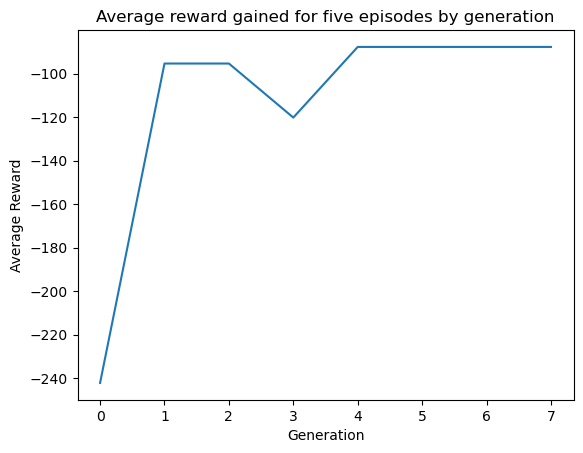

['(((x_3-x_6)*x_5)-((x_2/(-2.385016441345215*x_0))/((x_5-x_1)/(x_2/(-2.3710110187530518*x_0)))))', '(((3.700418472290039+(x_7/x_5))-((x_7/x_1)+(x_2--2.4111030101776123)))+(((x_3+x_7)-(x_0-x_5))-((x_3-x_7)*x_4)))', '((((x_0-x_2)+(x_5-x_6))-((x_1-x_6)-(x_3+x_2)))*(((x_0/x_2)/x_0)+((x_5*x_5)-(-3.279458522796631-x_7))))', '((((x_3-x_3)*(x_4*x_3))+1.7052545547485352)+(((-0.047547366470098495/x_0)-x_7)*x_5))']
-438.67783153809097


In [62]:
#gen_counter =0
gen = range(len(evo.best_of_gens)) #generation
avg_rewards = [] #average reward
for i in evo.best_of_gens:
    #print("for gen",gen_counter)
    avg_reward = get_test_score(i)/5
    avg_rewards.append(avg_reward)
    #print("average reward was:",avg_reward)
    #print("fitness was:",i.fitness)
    #gen_counter += 1
#print("best of gens",evo.best_of_gens)

#plot generation vs fitness
fig, ax = plt.subplots()
ax.plot(gen,avg_rewards)
ax.set_xlabel('Generation')
ax.set_ylabel('Average Reward')
ax.set_title('Average reward gained for five episodes by generation')

plt.show()

best = evo.best_of_gens[-1]
print(best.get_readable_repr())
print(get_test_score(best))

## Make an animation
Here the best evolved individual is selected and one episode is rendered. Make sure to save your lunar landers over time to track progress and make comparisons.

In [63]:
#test imagemagick
#!magick --version

#!conda install -c conda-forge imagemagick

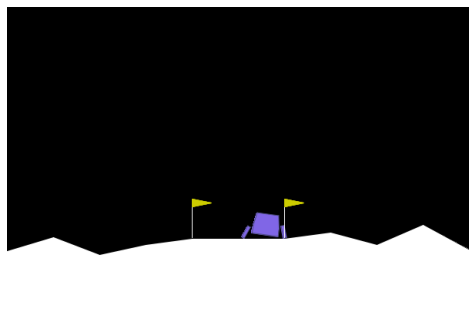

In [64]:
frames = []

# gist to save gif from https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def save_frames_as_gif(frames, path='./', filename='evolved_lander.gif'):
  plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  def animate(i):
      patch.set_data(frames[i])
  anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
  anim.save(path + filename, writer='imagemagick', fps=60)

frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames)

## Play animation

<img src="evolved_lander.gif" width="750">

## Optimisation
The coefficients in the multi-tree aren't optimised. Here Q-learning (taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) is used to optimise the weights further. Incorporate coefficient optimisation in training your agent(s). Coefficient Optimisation can be expensive. Think about how often you want to optimise, when, which individuals etc.

In [65]:
batch_size = 128
GAMMA = 0.99

constants = best.get_subtrees_consts()
print("before", get_test_score(best))
if len(constants)>0:
  optimizer = optim.AdamW(constants, lr=1e-3, amsgrad=True)

for _ in range(500):

  if len(constants)>0 and len(evo.memory)>batch_size:
    target_tree = copy.deepcopy(best)

    transitions = evo.memory.sample(batch_size)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                               if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = best.get_output_pt(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(batch_size, dtype=torch.float)
    with torch.no_grad():
      next_state_values[non_final_mask] = target_tree.get_output_pt(non_final_next_states).max(1)[0].float()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
   
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(constants, 100)
    optimizer.step()

print(best.get_readable_repr())
print("after", get_test_score(best))

before -438.67783153809097
['(((x_3-x_6)*x_5)-((x_2/(-2.8479115962982178*x_0))/((x_5-x_1)/(x_2/(-2.8339755535125732*x_0)))))', '(((4.085734844207764+(x_7/x_5))-((x_7/x_1)+(x_2--1.9952694177627563)))+(((x_3+x_7)-(x_0-x_5))-((x_3-x_7)*x_4)))', '((((x_0-x_2)+(x_5-x_6))-((x_1-x_6)-(x_3+x_2)))*(((x_0/x_2)/x_0)+((x_5*x_5)-(-3.7444286346435547-x_7))))', '((((x_3-x_3)*(x_4*x_3))+2.1837971210479736)+(((-0.11600537598133087/x_0)-x_7)*x_5))']
after -420.9263089123902


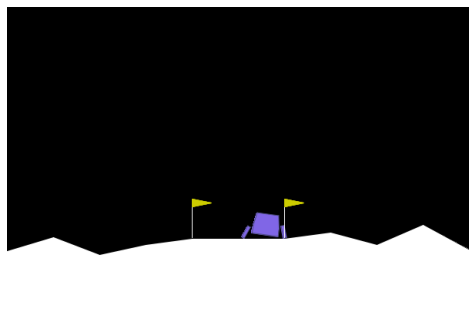

In [66]:
frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames, filename='evolved_lander_RL.gif')

<img src="evolved_lander_RL.gif" width="750">